In [1]:
pip install pandas numpy torch torchvision opencv-python-headless scikit-learn matplotlib albumentations ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
# Install all required packages
!pip install -q pandas numpy torch torchvision opencv-python-headless scikit-learn matplotlib scikit-image tqdm ultralytics seaborn

# Import all libraries for the project
import os
import cv2
import pandas as pd
import numpy as np
from skimage import measure
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress minor warnings and set the primary device for computation
warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Setup Complete: Using device: {device} ---")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
--- Setup Complete: Using device: cuda ---


In [3]:
# --- Helper functions to create bounding boxes from masks ---
def mask_to_bbox(mask):
    contours = measure.find_contours(mask, 0.5)
    if not contours: return None
    all_points = np.concatenate(contours, axis=0)
    y_min, x_min = all_points.min(axis=0)
    y_max, x_max = all_points.max(axis=0)
    return int(x_min), int(y_min), int(x_max), int(y_max)

def get_peripapillary_bbox(disc_bbox, img_shape, scale_factor=2.5):
    dx_min, dy_min, dx_max, dy_max = disc_bbox
    img_h, img_w = img_shape[:2]
    center_x, center_y = (dx_min + dx_max) / 2, (dy_min + dy_max) / 2
    width, height = dx_max - dx_min, dy_max - dy_min
    new_width, new_height = width * scale_factor, height * scale_factor
    px_min = max(0, int(center_x - new_width / 2))
    py_min = max(0, int(center_y - new_height / 2))
    px_max = min(img_w - 1, int(center_x + new_width / 2))
    py_max = min(img_h - 1, int(center_y + new_height / 2))
    return px_min, py_min, px_max, py_max

# --- Generic function to process each dataset ---
def process_dataset(image_dir, mask_dir, dataset_name, labels_df=None):
    print(f"Processing {dataset_name} dataset...")
    data_list = []
    for filename in tqdm(os.listdir(image_dir), desc=f"Processing {dataset_name}"):
        if not filename.lower().endswith(('.jpg', '.png', '.bmp')): continue
        base_name, image_path = os.path.splitext(filename)[0], os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, f"{base_name}.png")
        if not os.path.exists(mask_path): continue

        if dataset_name == 'REFUGE':
            label = 1 if base_name.lower().startswith(('g', 'ts')) else 0
        elif labels_df is not None:
            label_row = labels_df[labels_df['image_name'] == filename]
            if label_row.empty: continue
            label = label_row['label'].iloc[0]
        else: continue

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None: continue
        disc_binary_mask, disc_bbox = np.uint8(mask > 0), mask_to_bbox(np.uint8(mask > 0))
        if disc_bbox:
            peri_bbox = get_peripapillary_bbox(disc_bbox, mask.shape)
            data_list.append({
                'image_path': image_path, 'label': label,
                'disc_x_min': disc_bbox[0], 'disc_y_min': disc_bbox[1], 'disc_x_max': disc_bbox[2], 'disc_y_max': disc_bbox[3],
                'peri_x_min': peri_bbox[0], 'peri_y_min': peri_bbox[1], 'peri_x_max': peri_bbox[2], 'peri_y_max': peri_bbox[3],
                'dataset': dataset_name
            })
    return data_list

# --- DEFINE YOUR KAGGLE DATASET PATHS HERE ---
refuge_train_img_dir = '/kaggle/input/glaucoma-datasets/REFUGE/train/Images_Cropped'
refuge_train_mask_dir = '/kaggle/input/glaucoma-datasets/REFUGE/train/Masks_Cropped'
refuge_test_img_dir = '/kaggle/input/glaucoma-datasets/REFUGE/test/Images_Cropped'
refuge_test_mask_dir = '/kaggle/input/glaucoma-datasets/REFUGE/test/Masks_Cropped'
origa_img_dir = '/kaggle/input/glaucoma-datasets/ORIGA/Images'
origa_mask_dir = '/kaggle/input/glaucoma-datasets/ORIGA/Masks'
origa_labels_csv = '/kaggle/input/glaucoma-datasets/ORIGA/OrigaList.csv'
# ---

# --- Main Execution ---
refuge_train_data = process_dataset(refuge_train_img_dir, refuge_train_mask_dir, 'REFUGE')
refuge_test_data = process_dataset(refuge_test_img_dir, refuge_test_mask_dir, 'REFUGE')
try:
    origa_labels_df = pd.read_csv(origa_labels_csv).rename(columns={'Filename': 'image_name', 'Glaucoma': 'label'})
    origa_data = process_dataset(origa_img_dir, origa_mask_dir, 'ORIGA', labels_df=origa_labels_df)
except FileNotFoundError:
    print(f"Warning: ORIGA labels file not found. Skipping.")
    origa_data = []

all_data = refuge_train_data + refuge_test_data + origa_data
if not all_data:
    print("FATAL: No data was processed. Please check your file paths.")
else:
    master_df = pd.DataFrame(all_data)
    output_csv_path = '/kaggle/working/master_glaucoma_dataset.csv'
    master_df.to_csv(output_csv_path, index=False)
    print(f"\n--- Data Pre-processing Complete. Master dataset saved to: {output_csv_path} ---")

Processing REFUGE dataset...


Processing REFUGE:   0%|          | 0/400 [00:00<?, ?it/s]

Processing REFUGE dataset...


Processing REFUGE:   0%|          | 0/400 [00:00<?, ?it/s]

Processing ORIGA dataset...


Processing ORIGA:   0%|          | 0/650 [00:00<?, ?it/s]


--- Data Pre-processing Complete. Master dataset saved to: /kaggle/working/master_glaucoma_dataset.csv ---



--- Initial Dataset Class Distribution ---
label
0    1242
1     208
Name: count, dtype: int64


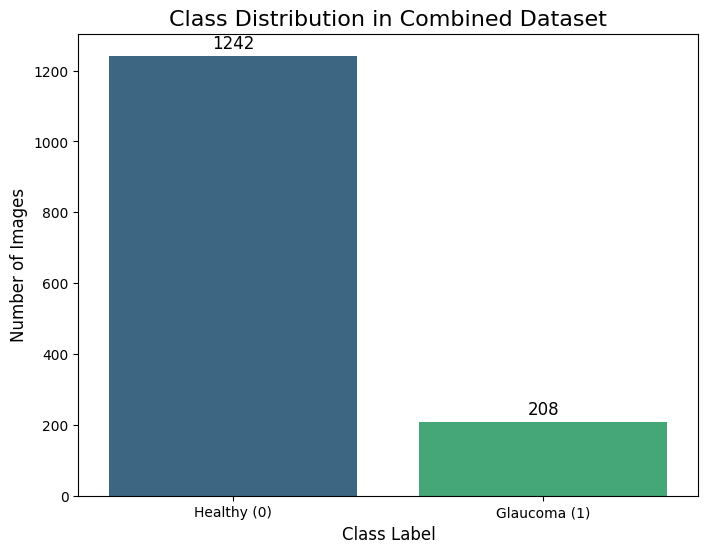

In [4]:
# Load the master dataset
MASTER_CSV_PATH = '/kaggle/working/master_glaucoma_dataset.csv'
master_df = pd.read_csv(MASTER_CSV_PATH)

# Analyze and print the class distribution
print("\n--- Initial Dataset Class Distribution ---")
class_counts = master_df['label'].value_counts()
print(class_counts)

# Visualize the class imbalance
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title('Class Distribution in Combined Dataset', fontsize=16)
plt.ylabel('Number of Images', fontsize=12)
plt.xlabel('Class Label', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Healthy (0)', 'Glaucoma (1)'])
for index, value in enumerate(class_counts):
    plt.text(index, value + 10, str(value), ha='center', va='bottom', fontsize=12)
plt.show()

In [5]:
# --- 1. YOLO "Child" Model (with Placeholder) ---
yolo_model = YOLO('yolov8n.pt')

def get_vcdr_from_yolo(image_paths_batch):
    # Placeholder returns a random VCDR value for each image
    return torch.tensor(np.random.uniform(0.3, 0.9, len(image_paths_batch)), dtype=torch.float32).to(device)

# --- 2. Custom Dataset for Cropped Regions ---
class GlaucomaDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = cv2.cvtColor(cv2.imread(row['image_path']), cv2.COLOR_BGR2RGB)
        disc_crop = image[row['disc_y_min']:row['disc_y_max'], row['disc_x_min']:row['disc_x_max']]
        peri_crop = image[row['peri_y_min']:row['peri_y_max'], row['peri_x_min']:row['peri_x_max']]
        disc_img = Image.fromarray(disc_crop)
        peri_img = Image.fromarray(peri_crop)
        if self.transforms:
            disc_img = self.transforms(disc_img)
            peri_img = self.transforms(peri_img)
        return disc_img, peri_img, torch.tensor(row['label'], dtype=torch.float32), row['image_path']

# --- 3. SpecialistEnsemble Model (from your notebook) ---
class SpecialistEnsemble(nn.Module):
    def __init__(self):
        super(SpecialistEnsemble, self).__init__()
        self.disc_specialist = models.resnet18(pretrained=True)
        self.disc_specialist.fc = nn.Linear(self.disc_specialist.fc.in_features, 256)
        self.peri_specialist = models.resnet18(pretrained=True)
        self.peri_specialist.fc = nn.Linear(self.peri_specialist.fc.in_features, 256)
        self.attention = nn.Sequential(nn.Linear(512, 128), nn.ReLU(), nn.Linear(128, 512), nn.Sigmoid())
        
    def forward(self, disc_img, peri_img):
        disc_features, peri_features = self.disc_specialist(disc_img), self.peri_specialist(peri_img)
        combined = torch.cat((disc_features, peri_features), dim=1)
        attention_weights = self.attention(combined)
        return combined * attention_weights

# --- 4. Hybrid Parent-Child Model ---
class HybridGlaucomaModel(nn.Module):
    def __init__(self, num_classes=1):
        super(HybridGlaucomaModel, self).__init__()
        self.cnn_parent = SpecialistEnsemble()
        self.classifier = nn.Sequential(
            nn.Linear(512 + 1, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, num_classes)
        )

    def forward(self, disc_img, peri_img, vcdr):
        image_features = self.cnn_parent(disc_img, peri_img)
        combined_features = torch.cat((image_features, vcdr.unsqueeze(1)), dim=1)
        return self.classifier(combined_features)

# --- 5. Data Transforms (with Augmentation for Training) ---
IMG_SIZE = 224
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15), transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(), transforms.Normalize(mean, std)
])
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor(), transforms.Normalize(mean, std)
])

print("--- Model Architectures and Data Handlers Defined ---")

--- Model Architectures and Data Handlers Defined ---


In [6]:
# --- 1. Load Data and Create Dataloaders ---
train_df, val_df = train_test_split(master_df, test_size=0.2, random_state=42, stratify=master_df['label'])
train_dataset = GlaucomaDataset(df=train_df, transforms=train_transforms)
val_dataset = GlaucomaDataset(df=val_df, transforms=val_transforms)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=False, num_workers=2)
print(f"\n--- Data Loaded: {len(train_dataset)} training samples, {len(val_dataset)} validation samples ---")

# --- 2. Initialize Model, Loss, Optimizer, and History ---
model = HybridGlaucomaModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
NUM_EPOCHS = 25
best_val_auc = 0.0
history = {'train_loss': [], 'val_auc': []}

# --- 3. The Training and Validation Loop ---
print("\n--- Starting Model Training ---")
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False)
    for disc_imgs, peri_imgs, labels, image_paths in progress_bar:
        disc_imgs, peri_imgs, labels = disc_imgs.to(device), peri_imgs.to(device), labels.to(device).unsqueeze(1)
        vcdrs = get_vcdr_from_yolo(image_paths)
        outputs = model(disc_imgs, peri_imgs, vcdrs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    epoch_train_loss = running_loss / len(train_loader)
    history['train_loss'].append(epoch_train_loss)
    
    model.eval()
    all_labels, all_preds_scores = [], []
    with torch.no_grad():
        for disc_imgs, peri_imgs, labels, image_paths in val_loader:
            disc_imgs, peri_imgs = disc_imgs.to(device), peri_imgs.to(device)
            vcdrs = get_vcdr_from_yolo(image_paths)
            scores = torch.sigmoid(model(disc_imgs, peri_imgs, vcdrs)).cpu().numpy().flatten()
            all_labels.extend(labels.cpu().numpy())
            all_preds_scores.extend(scores)
            
    epoch_val_auc = roc_auc_score(all_labels, all_preds_scores)
    history['val_auc'].append(epoch_val_auc)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {epoch_train_loss:.4f} | Val AUC: {epoch_val_auc:.4f}")
    
    if epoch_val_auc > best_val_auc:
        best_val_auc = epoch_val_auc
        torch.save(model.state_dict(), 'best_hybrid_model.pth')
        print(f"✨ New best model saved with AUC: {best_val_auc:.4f}")

print(f"\n--- Training Complete --- Best Val AUC: {best_val_auc:.4f} ---")


--- Data Loaded: 1160 training samples, 290 validation samples ---


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]



--- Starting Model Training ---


Epoch 1/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 1/25 - Train Loss: 0.3522 | Val AUC: 0.8790
✨ New best model saved with AUC: 0.8790


Epoch 2/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 2/25 - Train Loss: 0.2530 | Val AUC: 0.8839
✨ New best model saved with AUC: 0.8839


Epoch 3/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 3/25 - Train Loss: 0.2356 | Val AUC: 0.8757


Epoch 4/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 4/25 - Train Loss: 0.1932 | Val AUC: 0.8988
✨ New best model saved with AUC: 0.8988


Epoch 5/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 5/25 - Train Loss: 0.1712 | Val AUC: 0.8975


Epoch 6/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 6/25 - Train Loss: 0.1499 | Val AUC: 0.8592


Epoch 7/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 7/25 - Train Loss: 0.1156 | Val AUC: 0.8803


Epoch 8/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 8/25 - Train Loss: 0.1155 | Val AUC: 0.8880


Epoch 9/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 9/25 - Train Loss: 0.0871 | Val AUC: 0.9003
✨ New best model saved with AUC: 0.9003


Epoch 10/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 10/25 - Train Loss: 0.1060 | Val AUC: 0.9140
✨ New best model saved with AUC: 0.9140


Epoch 11/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 11/25 - Train Loss: 0.0846 | Val AUC: 0.8972


Epoch 12/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 12/25 - Train Loss: 0.0827 | Val AUC: 0.8907


Epoch 13/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 13/25 - Train Loss: 0.0701 | Val AUC: 0.8945


Epoch 14/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 14/25 - Train Loss: 0.0486 | Val AUC: 0.9021


Epoch 15/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 15/25 - Train Loss: 0.0359 | Val AUC: 0.9026


Epoch 16/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 16/25 - Train Loss: 0.0521 | Val AUC: 0.8724


Epoch 17/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 17/25 - Train Loss: 0.0576 | Val AUC: 0.9126


Epoch 18/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 18/25 - Train Loss: 0.0533 | Val AUC: 0.9260
✨ New best model saved with AUC: 0.9260


Epoch 19/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 19/25 - Train Loss: 0.0274 | Val AUC: 0.8979


Epoch 20/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 20/25 - Train Loss: 0.0450 | Val AUC: 0.9003


Epoch 21/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 21/25 - Train Loss: 0.0375 | Val AUC: 0.8822


Epoch 22/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 22/25 - Train Loss: 0.0241 | Val AUC: 0.9085


Epoch 23/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 23/25 - Train Loss: 0.0497 | Val AUC: 0.9134


Epoch 24/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 24/25 - Train Loss: 0.0375 | Val AUC: 0.9357
✨ New best model saved with AUC: 0.9357


Epoch 25/25:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 25/25 - Train Loss: 0.0511 | Val AUC: 0.9041

--- Training Complete --- Best Val AUC: 0.9357 ---



--- Results will be saved in the 'project_results' directory ---


Final Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]


Generating and saving training history plots...


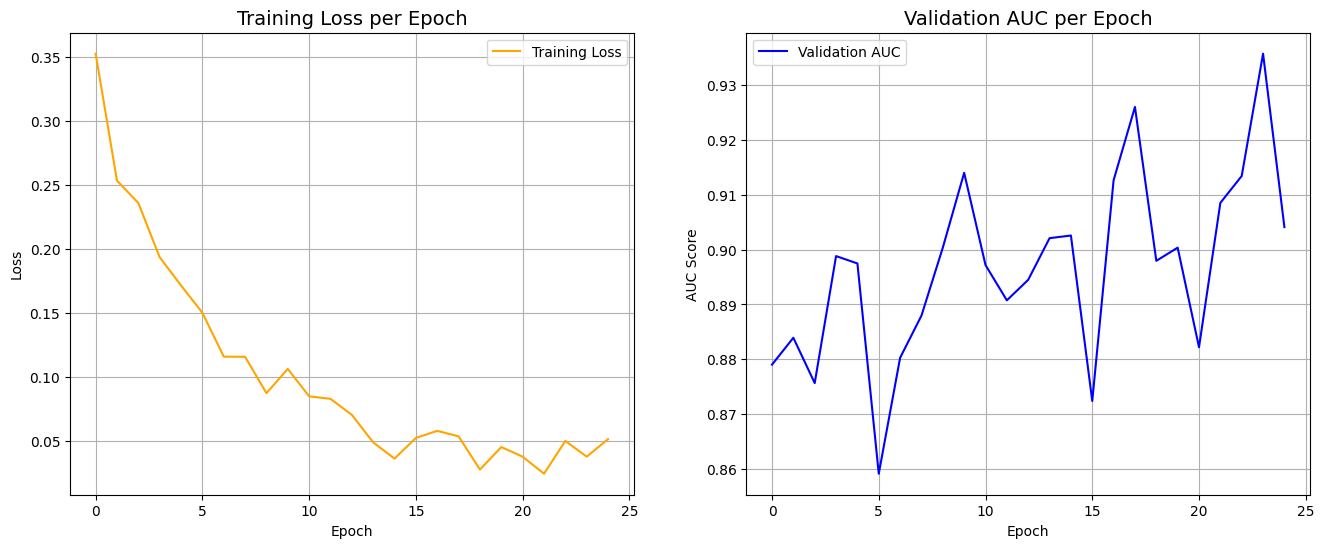


Generating and saving classification report...

      DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

 Healthy (0)       0.94      0.96      0.95       248
Glaucoma (1)       0.75      0.64      0.69        42

    accuracy                           0.92       290
   macro avg       0.85      0.80      0.82       290
weighted avg       0.91      0.92      0.91       290

Classification report image saved to: project_results/classification_report.png

Generating and saving confusion matrix...


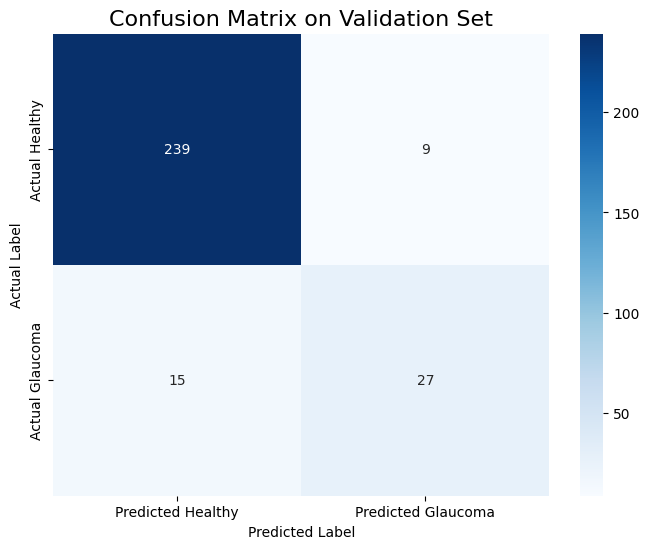

Confusion matrix plot saved to: project_results/confusion_matrix.png

--- All results have been generated and saved! ---


In [7]:
# --- Create a directory to save all result images ---
RESULTS_DIR = 'project_results'
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"\n--- Results will be saved in the '{RESULTS_DIR}' directory ---")

# --- 1. Load the Best Saved Model ---
model = HybridGlaucomaModel().to(device)
MODEL_SAVE_PATH = 'best_hybrid_model.pth'
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
model.eval()

# --- 2. Get Final Predictions on Validation Set ---
all_labels, all_preds_binary, all_preds_scores = [], [], []
with torch.no_grad():
    for disc_imgs, peri_imgs, labels, image_paths in tqdm(val_loader, desc="Final Evaluation"):
        disc_imgs, peri_imgs = disc_imgs.to(device), peri_imgs.to(device)
        vcdrs = get_vcdr_from_yolo(image_paths)
        scores = torch.sigmoid(model(disc_imgs, peri_imgs, vcdrs)).cpu().numpy().flatten()
        all_labels.extend(labels.cpu().numpy().flatten())
        all_preds_scores.extend(scores)
        all_preds_binary.extend((scores > 0.5).astype(int))

# --- 3. Generate and Save All Plots and Reports ---

# A) Plot and Save Training History
print("\nGenerating and saving training history plots...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(history['train_loss'], label='Training Loss', color='orange')
ax1.set_title('Training Loss per Epoch', fontsize=14)
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.grid(True); ax1.legend()
ax2.plot(history['val_auc'], label='Validation AUC', color='blue')
ax2.set_title('Validation AUC per Epoch', fontsize=14)
ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC Score'); ax2.grid(True); ax2.legend()
training_plot_path = os.path.join(RESULTS_DIR, 'training_performance.png')
plt.savefig(training_plot_path, dpi=300, bbox_inches='tight')
plt.show()

# B) Generate and Save Classification Report
print("\nGenerating and saving classification report...")
report = classification_report(all_labels, all_preds_binary, target_names=['Healthy (0)', 'Glaucoma (1)'])
print("\n" + "="*50 + "\n      DETAILED CLASSIFICATION REPORT\n" + "="*50)
print(report)
fig, ax = plt.subplots(figsize=(8, 5))
ax.text(0.05, 0.95, report, transform=ax.transAxes, fontsize=12, va='top', fontfamily='monospace')
ax.axis('off'); plt.title('Classification Report', fontsize=16)
report_save_path = os.path.join(RESULTS_DIR, 'classification_report.png')
plt.savefig(report_save_path, dpi=300, bbox_inches='tight'); plt.close()
print(f"Classification report image saved to: {report_save_path}")

# C) Generate and Save Confusion Matrix
print("\nGenerating and saving confusion matrix...")
cm = confusion_matrix(all_labels, all_preds_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Healthy', 'Predicted Glaucoma'], yticklabels=['Actual Healthy', 'Actual Glaucoma'])
plt.ylabel('Actual Label'); plt.xlabel('Predicted Label'); plt.title('Confusion Matrix on Validation Set', fontsize=16)
cm_save_path = os.path.join(RESULTS_DIR, 'confusion_matrix.png')
plt.savefig(cm_save_path, dpi=300, bbox_inches='tight'); plt.show()
print(f"Confusion matrix plot saved to: {cm_save_path}")

print("\n--- All results have been generated and saved! ---")